# CNN test 2

Plan B is to follow the architecture in the paper: https://arxiv.org/abs/2203.16703

Basically, we create four separate CNNs for each layer and add their fully connected layers back together at the end.

In [2]:
import os
import time
import h5py
import numpy as np
import math
from sklearn.preprocessing import StandardScaler

from icecream import ic

from tqdm import tqdm, trange
from matplotlib import pyplot as plt
from pprint import pprint

In [3]:
plt.rcParams["figure.dpi"] = 80

In [4]:
# Utility functions and whatnot
def convert_size(size_bytes):
    if size_bytes == 0:
        return "0B"
    size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
    i = int(math.floor(math.log(size_bytes, 1024)))
    p = math.pow(1024, i)
    s = round(size_bytes / p, 2)
    return "%s %s" % (s, size_name[i])


class_labels = ["pion", "photon", "scalar"]

In [5]:
data_dir = "/usatlas/atlas01/atlasdisk/users/atlas_wifeng/photon-jet/data/processed/scalar_test"
os.chdir(data_dir)

In [6]:
# Grab the data
all_jets = dict(np.load("all_jets_no_transform.npz"))

for layer, arr in all_jets.items():
    print(
        layer.ljust(10),
        str(arr.dtype).ljust(15),
        str(arr.shape).ljust(20),
        convert_size(arr.nbytes)
    )

layer_0    float64         (300000, 4, 16)      146.48 MB
layer_1    float64         (300000, 4, 128)     1.14 GB
layer_2    float64         (300000, 16, 16)     585.94 MB
layer_3    float64         (300000, 16, 8)      292.97 MB
energy     float64         (300000, 1)          2.29 MB
overflow   float64         (300000, 4)          9.16 MB
label      int64           (300000,)            2.29 MB


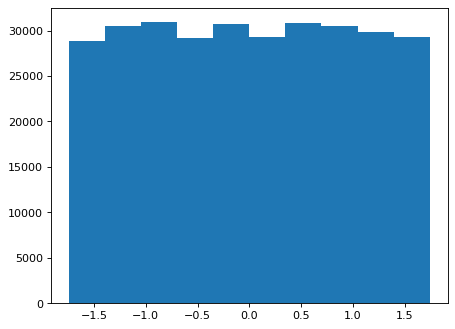

In [7]:
# Normalize "energy" and "overflow"
all_jets["energy"] = StandardScaler().fit_transform(all_jets["energy"])
plt.hist(all_jets["energy"]);

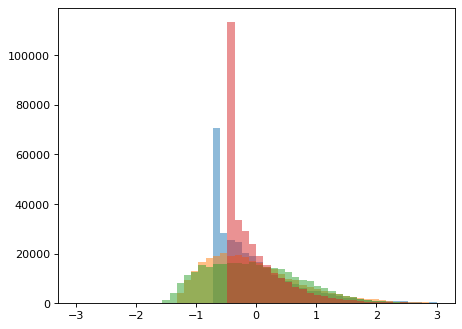

In [8]:
all_jets["overflow"] = StandardScaler().fit_transform(all_jets["overflow"])

for col in all_jets["overflow"].T:
    plt.hist(col, bins=50, range=[-3, 3], alpha=0.5)

## Visualize some data

Just to see what jets look like. Utility functions defined here:
- `nth_jet(n)`: displays the `n`th jet from `all_jets`
- `graph_jet(jet)`: graphs a jet (a dict with `energy`, `layer_0`, ..., `label` keys)

TODO: add together stuff for each class

In [9]:
def nth_jet(n):
    jet = {}
    for layer in all_jets.keys():
        jet[layer] = all_jets[layer][n]
    return jet

def graph_jet(jet):
    fig, axs = plt.subplots(1, 4, figsize=(20, 4))
    for layer, ax in zip(["layer_0", "layer_1", "layer_2", "layer_3"], axs):
        im = ax.imshow(
            jet[layer].T,
            interpolation='none',
            cmap="viridis",
            extent=[-0.2, 0.2, -0.02, 0.02],
            aspect=10
        )
        ax.set_title(layer)
        
    fig.suptitle(class_labels[jet['label']])
    fig.colorbar(im, ax=axs.ravel().tolist())
    
    print(f"Layers for {class_labels[jet['label']]} (class {jet['label']})")
    plt.show()
    if "energy" in jet: print(f"energy:   {jet['energy']}")
    if "overflow" in jet: print(f"overflow: {jet['overflow']}")

Layers for pion (class 0)


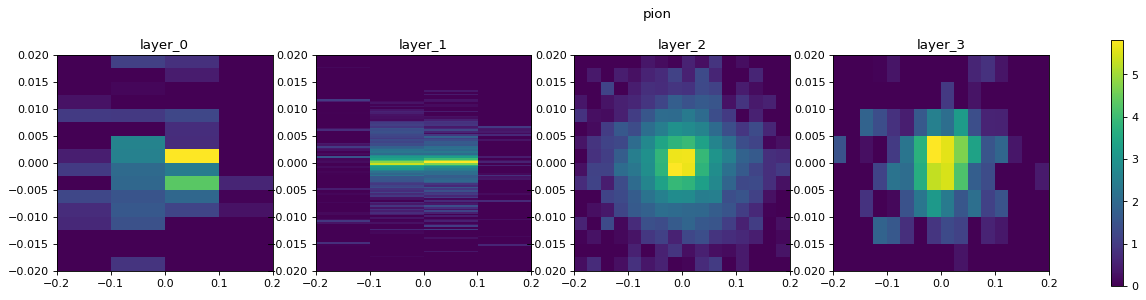

energy:   [-0.62279104]
overflow: [-0.20653526 -0.81031417  0.47707672 -0.1677785 ]
Layers for photon (class 1)


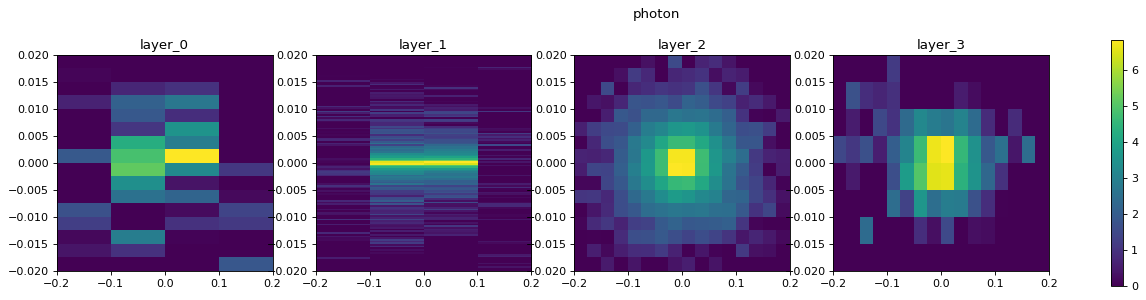

energy:   [0.74631713]
overflow: [-0.70969771 -0.12850804 -0.43575487 -0.41280204]
Layers for scalar (class 2)


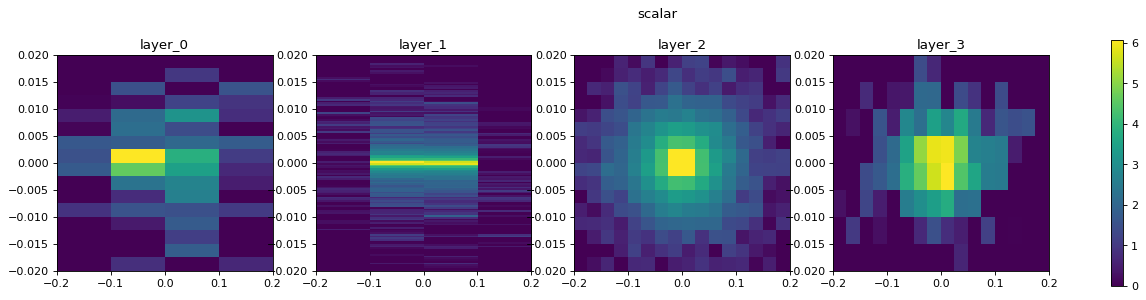

energy:   [1.63046989]
overflow: [ 0.59564905 -0.59896365  1.48386268  1.00701832]


In [10]:
example_idxs = [None] * 3
i = 0
while True:
    label = all_jets["label"][i]
    if example_idxs[label] == None:
        example_idxs[label] = i
    if all(x != None for x in example_idxs):
        break
    i += 1
    
for i in example_idxs:
    graph_jet(nth_jet(i))

### Graph "average jet" for each class

In [11]:
def graph_average_class(label):
    avgs = {}
    for layer in ["layer_0", "layer_1", "layer_2", "layer_3"]:
        print(f"Processing {layer}")
        arr = all_jets[layer][all_jets["label"] == label]
        avgs[layer] = arr.mean(axis=0)

    avgs["label"] = label
    graph_jet(avgs)

Processing layer_0
Processing layer_1
Processing layer_2
Processing layer_3
Layers for pion (class 0)


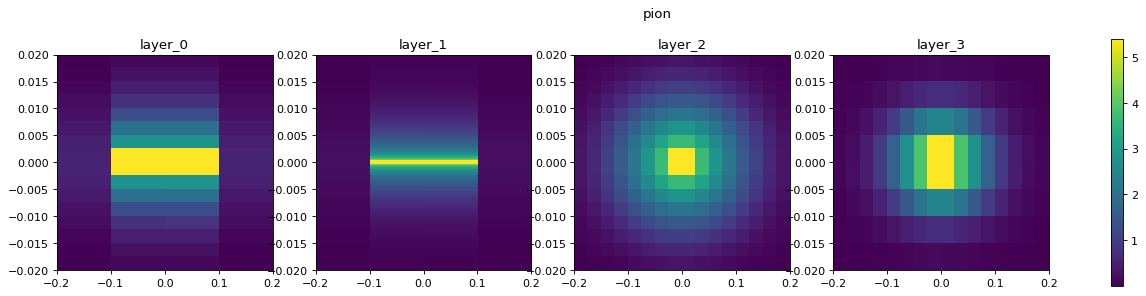

Processing layer_0
Processing layer_1
Processing layer_2
Processing layer_3
Layers for photon (class 1)


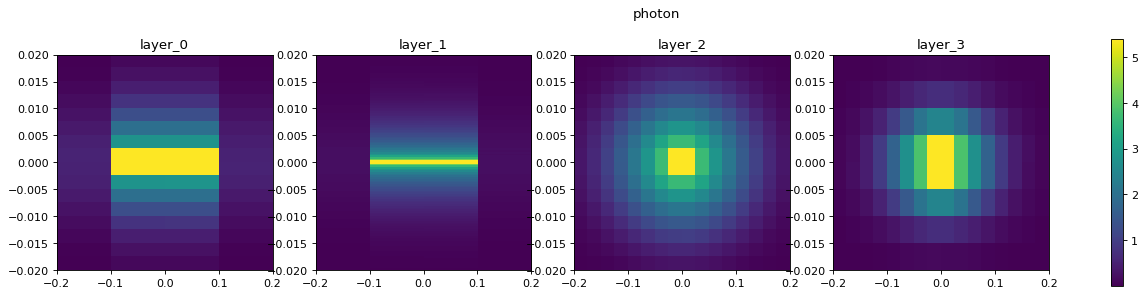

Processing layer_0
Processing layer_1
Processing layer_2
Processing layer_3
Layers for scalar (class 2)


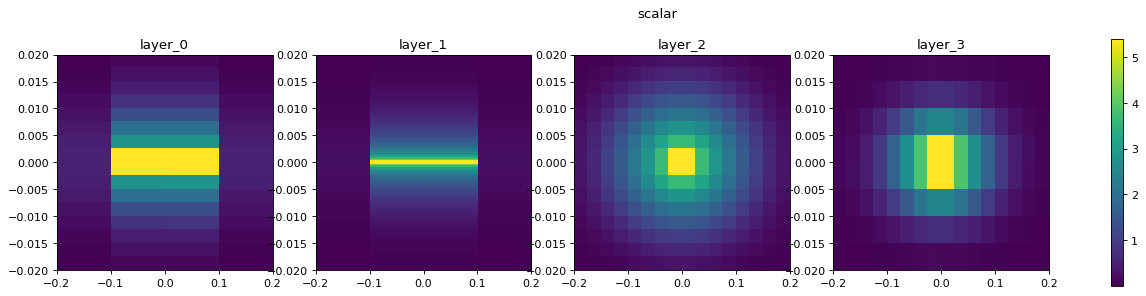

In [12]:
for i in range(3):
    graph_average_class(i)

## Split into train/dev/test

After this, we have three sets of jets:
- `jets_train` (210k)
- `jets_dev` (45k)
- `jets_test` (45k)

In [13]:
m = len(all_jets["label"])

f_train, f_dev, f_test = 0.7, 0.15, 0.15
n_train, n_dev, n_test = map(lambda x: int(m * x), (f_train, f_dev, f_test))

jets_train = {}
jets_dev = {}
jets_test = {}

for layer in all_jets.keys():
    print(f"Splitting layer {layer}...")
    jets_train[layer] = all_jets[layer][:n_train]
    jets_dev[layer] = all_jets[layer][n_train:(n_train + n_dev)]
    jets_test[layer] = all_jets[layer][(n_train + n_dev):]

Splitting layer layer_0...
Splitting layer layer_1...
Splitting layer layer_2...
Splitting layer layer_3...
Splitting layer energy...
Splitting layer overflow...
Splitting layer label...


In [14]:
def total_size(jets):
    res = 0
    for layer in jets:
        res += jets[layer].nbytes
    return convert_size(res)

print(f"n_train: {n_train} ({total_size(jets_train)})")
print(f"n_dev: {n_dev} ({total_size(jets_dev)})")
print(f"n_test: {n_test} ({total_size(jets_test)})")

n_train: 210000 (1.51 GB)
n_dev: 45000 (331.65 MB)
n_test: 45000 (331.65 MB)


## Create the model

Simple CNN.

In [15]:
import torch
from torchvision.transforms import Resize, InterpolationMode

In [16]:
for layer in all_jets.keys():
    print(layer.ljust(20), all_jets[layer].shape)

layer_0              (300000, 4, 16)
layer_1              (300000, 4, 128)
layer_2              (300000, 16, 16)
layer_3              (300000, 16, 8)
energy               (300000, 1)
overflow             (300000, 4)
label                (300000,)


In [33]:
class ConvBlock(torch.nn.Module):
    """
    Two convolutional layers, each:
        - 2D convolution with 3x3 filter, stride 1
        - ReLU activation
        - 2x2 maxpooling
    """    
    def __init__(self, channel_sizes):
        """
        img_shape: 2-tuple of image shape, e.g. (4, 128)
        channel_sizes: 2-tuple of cnn channel sizes, e.g. (12, 24)
        """
        super(ConvBlock, self).__init__()
        size = 64
        self.resize = Resize(size=(size, size), interpolation=InterpolationMode.NEAREST, antialias=False)
        
        self.cnn1 = torch.nn.Conv2d(in_channels=1, out_channels=channel_sizes[0], kernel_size=3, stride=1)
        self.maxpool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.maxpool1_bn = torch.nn.BatchNorm2d(channel_sizes[0])

        self.cnn2 = torch.nn.Conv2d(in_channels=channel_sizes[0], out_channels=channel_sizes[1], kernel_size=3, stride=1)
        self.maxpool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.maxpool2_bn = torch.nn.BatchNorm2d(channel_sizes[1])

        final_size = (((size - 2) // 2) - 2) // 2
        self.fc = torch.nn.Linear(channel_sizes[1] * final_size ** 2, 32)

    def forward(self, x):
        relu = torch.nn.functional.relu
        img = self.resize(x)

        conv1_out = relu(self.cnn1(img))
        pool1_out = self.maxpool1(conv1_out)
        pool1_out_bn = self.maxpool1_bn(pool1_out)

        conv2_out = relu(self.cnn2(pool1_out_bn))
        pool2_out = self.maxpool2(conv2_out)
        pool2_out_bn = self.maxpool2_bn(pool2_out)

        fc_input = pool2_out.flatten(start_dim=1)
        fc_out = relu(self.fc(fc_input))

        return fc_out

In [34]:
class CNNModel(torch.nn.Module):
    def __init__(self, cuda=True):
        super(CNNModel, self).__init__()
        self.blocks = torch.nn.ModuleList([ConvBlock((12, 24)) for _ in range(4)])
        self.fc1 = torch.nn.Linear(128, 32)
        self.fc2 = torch.nn.Linear(32, 32)

    def forward(self, x):
        relu = torch.nn.functional.relu
        
        # Give exram dimension
        layers = [x[f"layer_{i}"].unsqueeze(dim=1) for i in range(4)]        
        layers_out = [self.blocks[i](layers[i]) for i in range(4)]
        
        fcn_input = torch.cat(layers_out, dim=-1)  # Concatenate FC outputs together        
        fc1_out = relu(self.fc1(fcn_input))
        fc2_out = relu(self.fc2(fc1_out))

        return fc2_out

In [ ]:
class CNNModel(torch.nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Things for upsampling
        # "l0_tc" is "layer_0 transpose convolution"
        # https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html
        
        self.resize = Resize(size=(32, 32), interpolation=InterpolationMode.NEAREST, antialias=False)
        
        # Let's use LeNet: https://en.wikipedia.org/wiki/LeNet#/media/File:Comparison_image_neural_networks.svg
        channel_sizes = [10, 20]
        
        self.cnn1 = torch.nn.Conv2d(in_channels=4, out_channels=channel_sizes[0], kernel_size=5, stride=1, padding=2)
        self.maxpool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.maxpool1_bn = torch.nn.BatchNorm2d(channel_sizes[0])

        self.cnn2 = torch.nn.Conv2d(in_channels=channel_sizes[0], out_channels=channel_sizes[1], kernel_size=5, stride=1, padding=2)
        self.maxpool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.maxpool2_bn = torch.nn.BatchNorm2d(channel_sizes[1])

        self.fc1 = torch.nn.Linear(channel_sizes[1] * 8 * 8 + 5, 10)

    def forward(self, x):
        relu = torch.nn.functional.relu
        
        layer0 = self.resize(x["layer_0"])
        layer1 = self.resize(x["layer_1"])
        layer2 = self.resize(x["layer_2"])
        layer3 = self.resize(x["layer_3"])
        
        img = torch.stack([layer0, layer1, layer2, layer3], dim=1)

        conv1_out = relu(self.cnn1(img))
        pool1_out = self.maxpool1(conv1_out)
        pool1_out_bn = self.maxpool1_bn(pool1_out)

        conv2_out = relu(self.cnn2(pool1_out_bn))
        pool2_out = self.maxpool2(conv2_out)
        pool2_out_bn = self.maxpool2_bn(pool2_out)

        fcn_input = pool2_out.view(pool2_out_bn.size(0), -1)        
        fcn_input = torch.cat((fcn_input, x["energy"], x["overflow"]), dim=1)
        fc1_out = self.fc1(fcn_input)

        return fc1_out

### Select hyperparameters

In [46]:
torch.manual_seed(55)

model = CNNModel()

learning_rate = 1e-2
epochs = 10
batchsize = 50

loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

if torch.cuda.is_available():
    model = model.to(torch.device("cuda"))

In [44]:
import gc
gc.collect()
torch.cuda.empty_cache()

print("allocated:", convert_size(torch.cuda.memory_allocated()))
print("reserved:", convert_size(torch.cuda.memory_reserved()))

allocated: 1.02 GB
reserved: 1.98 GB


### Begin training

In [38]:
# Placeholders for training loss and dev accuracy during training
# Training loss should be tracked for each iteration (1 iteration -> single forward pass to the network)
# dev accuracy should be evaluated every 'Epoch' (1 epoch -> full training dataset)
# If using batch gradient, 1 iteration = 1 epoch

train_loss_list = []
train_accuracy_list = []
dev_accuracy_list = []

In [39]:
def to_torch(jets):
    res = {}
    for key in jets:
        res[key] = torch.from_numpy(jets[key])
        if np.issubdtype(jets[key].dtype, float):
            res[key] = res[key].float().to(0)
        elif np.issubdtype(jets[key].dtype, int):
            res[key] = res[key].long().to(0)
    return res

def split_batches(jets, batchsize):
    m = len(jets["label"])
    n_batches = m // batchsize
    
    d_wise = {}
    for key in jets:
        d_wise[key] = np.array_split(jets[key], n_batches)
        
    batches = []
    for i in range(n_batches):
        batches.append({key: d_wise[key][i] for key in d_wise})
    
    return batches

torch_dev = to_torch(jets_dev)
train_batched = split_batches(to_torch(jets_train), batchsize)

batch_split_num = len(train_batched)

In [ ]:
for epoch in range(5):
    correct = 0
    total = 0
    
    pbar = tqdm(range(batch_split_num))
    for b in pbar:
        optimizer.zero_grad()
        
        outputs = model(train_batched[b])
        loss = loss_func(outputs, train_batched[b]["label"])        
        loss.backward() # Compute gradients
        
        train_loss_list.append(loss.item())
        optimizer.step() # Update parameters        
        
        # Compute training accuracy
        predictions = torch.argmax(outputs, dim=1)
        correct += torch.sum((predictions == train_batched[b]["label"]).type(torch.FloatTensor)).item()
        total += len(train_batched[b]["label"])
        
        pbar.set_description(f"Train accuracy: {str(round(correct / total, 4)).ljust(3)}")
        
    train_accuracy_list.append(correct / len(jets_train["label"]))
        
#     # Compute dev accuracy
#     with torch.no_grad():
#         predictions = torch.argmax(model(torch_dev), dim=1)
#         correct = predictions == torch_dev["label"]
#         accuracy = torch.mean(correct.type(torch.FloatTensor))
#         dev_accuracy_list.append(accuracy.item())        
    
#     # Print a report
#     tl = str(round(train_loss_list[-1], 5)).ljust(7)      # Training loss
#     ta = str(round(train_accuracy_list[-1], 5)).ljust(7)  # Training accuracy
#     da = str(round(dev_accuracy_list[-1], 5)).ljust(7)    # Dev accuracy
#     desc = f"Epoch {epoch}, tl={tl}, ta={ta}, da={da}"
    
#     #pbar.set_description(desc)
#     print(desc)

Train accuracy: 0.3346:  81%|████████  | 34/42 [00:21<00:05,  1.57it/s]